In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# configure the GPU
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


[dataset](https://bcsiriuschen.github.io/CARC/)

In [2]:
base_directory = './datasets/CACD2000_small/'

In [3]:
filelist = os.listdir(base_directory)

In [4]:
names = [file.split("_")[1] + "_" + file.split("_")[2] for file in filelist]

In [5]:
def get_filesname(name):
    return [base_directory+file for file in filelist if name in file]

In [6]:
image_dims = (128, 128, 3)

In [7]:
def load_image(path):
    im = Image.open(path)
    im = im.resize(image_dims[:2])
    
    im = np.array(im).astype("float32")
    im = im / 255.0
    im = np.expand_dims(im, axis=0)
    return im

In [8]:
temp = get_filesname(names[0])

In [9]:
temp

['./datasets/CACD2000_small/14_Aaron_Johnson_0001.jpg',
 './datasets/CACD2000_small/14_Aaron_Johnson_0002.jpg']

In [10]:
import matplotlib.pyplot as plt
# resize the plt plot to 16, 16
plt.rcParams['figure.figsize'] = (8, 8)

In [11]:
from itertools import combinations, product
from random import randint, shuffle
import os

class ImageLoader:
    def __init__(self, base_directory, image_dims, batch_size=32):
        self.base_directory = base_directory
        self.image_dims = image_dims
        self.batch_size = batch_size
        self.current_name = 0
        self.image_l_queue = []
        self.image_r_queue = []
        self.label_queue = []

    def load_image(self, path):
        im = Image.open(path)
        im = im.resize(self.image_dims[:2])
        
        im = np.array(im).astype("float32")
        im = im / 255.0
        # im = np.expand_dims(im, axis=0)
        return im

    def reset(self):
        self.current_name = 0
        self.image_l_queue = []
        self.image_r_queue = []
        self.label_queue = []

    def next_batch(self):
        # load the next batch
        if len(self.image_l_queue) < self.batch_size:
            # load the next set of images
            try:
                name = names[self.current_name]
            except:
                return -1

            invalid_name = names[randint(0, len(names)-1)]

            files = get_filesname(name)
            c_images = []
            for file in files:
                c_images.append(self.load_image(file))

            c_images = np.array(c_images, dtype=np.float32)

            for a, b in combinations(c_images, 2):
                self.image_l_queue.append(a)
                self.image_r_queue.append(b)
                self.label_queue.append([1])

            files = get_filesname(invalid_name)[:len(c_images)]
            i_images = []
            for file in files:
                i_images.append(self.load_image(file))

            for a, b in product(c_images, i_images):
                self.image_l_queue.append(a)
                self.image_r_queue.append(b)
                self.label_queue.append([0])

            zipped = list(zip(self.image_l_queue, self.image_r_queue, self.label_queue))
            shuffle(zipped)
            self.image_l_queue, self.image_r_queue, self.label_queue = zip(*zipped)

            self.image_l_queue = list(self.image_l_queue)
            self.image_r_queue = list(self.image_r_queue)
            self.label_queue = list(self.label_queue)

            self.current_name += 1

        # return the current batch
        to_return = (
            np.array(self.image_l_queue[:self.batch_size], dtype=np.float32), 
            np.array(self.image_r_queue[:self.batch_size], dtype=np.float32),
            np.array(self.label_queue[:self.batch_size], dtype=np.float32)
        )

        del [
            self.image_l_queue[:self.batch_size],
            self.image_r_queue[:self.batch_size],
            self.label_queue[:self.batch_size]
        ]

        return to_return

In [12]:
loader = ImageLoader(base_directory, image_dims)

In [13]:
img_1, img_2, labels = loader.next_batch()

In [14]:
test = np.array([img_1, img_2], dtype=np.float32)

In [15]:
image_dims=(128, 128, 3)

In [16]:
def load_vgg():
    vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=image_dims)
    vgg.trainable = False
    return vgg

In [19]:
def vgg_embedding():
    input=tf.keras.Input(shape=image_dims, name="image input")
    vgg = load_vgg()(input)
    vgg = tf.keras.layers.Flatten()(vgg)
    dense = tf.keras.layers.Dense(4028, activation='relu')(vgg)
    return keras.Model(inputs=input, outputs=dense, name="embedding")

In [20]:
def make_embedding():
    # does not use vgg
    inp = Input(shape=image_dims, name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(1024, activation='sigmoid')(f1)
    
    
    return keras.Model(inputs=[inp], outputs=[d1], name='embedding')


In [21]:
def siamese():
    input_a = tf.keras.Input(shape=image_dims, name="image a")
    input_b = tf.keras.Input(shape=image_dims, name="image b")

    embedding = vgg_embedding()
    embedding_a = embedding(input_a)
    embedding_b = embedding(input_b)

    l1_distance = tf.keras.layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([embedding_a, embedding_b])
    prediction = tf.keras.layers.Dense(1, activation='sigmoid')(l1_distance)
    
    return tf.keras.Model(inputs=[input_a, input_b], outputs=[prediction], name="siamese")

In [22]:
model = siamese()
BCE = keras.losses.BinaryCrossentropy()
adam = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=adam, loss=BCE, metrics=['accuracy'])

In [23]:
model.summary()

Model: "siamese"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image a (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 image b (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4028)         47716092    ['image a[0][0]',                
                                                                  'image b[0][0]']          

In [24]:
chechpoint_dir = "./checkpoints"
checkpoint_prefix=os.path.join(chechpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(model=model, optimizer=adam)

In [25]:
@tf.function
def train_step(img_1, img_2, labels):
    # images -> (2, 128, 128, 3)
    # labels -> (1, 1)
    with tf.GradientTape() as tape:
        # image.reshape(2, 32, 128, 128, 3)
    
        predictions = model([img_1, img_2])
        accuracy = tf.reduce_mean(tf.cast(tf.equal(labels, predictions), tf.float32))
        loss = BCE(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    adam.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, accuracy

In [26]:
img_1, img_2, labels = loader.next_batch()

In [27]:
train_step(img_1, img_2, labels)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.56866276>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)

In [28]:
tf.config.run_functions_eagerly(True)

In [29]:
from helper import ProgressBar

EPOCHS = 5
num_names = len(names)

for epoch in range(EPOCHS):
    progbar = keras.utils.Progbar(num_names)
    loader.reset()
    print("Epoch {}/{}".format(epoch+1, EPOCHS))
    k = loader.next_batch()
    while(k != -1):
        current_number = loader.current_name
        loss, accuracy = train_step(*k)

        progbar.update(current_number)
        k = loader.next_batch()

    print("Loss: {}".format(loss))
    print("Saving checkpoint...")

    checkpoint.save(file_prefix=checkpoint_prefix)

Epoch 1/5
636/636 [==============================] - 862s 1s/step
Loss: 0.26168227195739746
Saving checkpoint...
Epoch 2/5
636/636 [==============================] - 852s 1s/step
Loss: 0.07702361792325974
Saving checkpoint...
Epoch 3/5
636/636 [==============================] - 839s 1s/step
Loss: 0.045522794127464294
Saving checkpoint...
Epoch 4/5
636/636 [==============================] - 812s 1s/step
Loss: 0.038277529180049896
Saving checkpoint...
Epoch 5/5
636/636 [==============================] - 826s 1s/step
Loss: 0.12092975527048111
Saving checkpoint...


In [34]:
model.save_weights("./models/aging_face")

<h1>Run from here for demonstration</h1>

**Note:**
Please download the required models from this link: [click me]() and extract it in the same folder as this notebook.

In [36]:
def load_vgg():
    vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=image_dims)
    vgg.trainable = False
    return vgg

def make_embedding():
    # does not use vgg
    inp = Input(shape=image_dims, name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(1024, activation='sigmoid')(f1)
    
    
    return keras.Model(inputs=[inp], outputs=[d1], name='embedding')

def siamese():
    input_a = tf.keras.Input(shape=image_dims, name="image a")
    input_b = tf.keras.Input(shape=image_dims, name="image b")

    embedding = vgg_embedding()
    embedding_a = embedding(input_a)
    embedding_b = embedding(input_b)

    l1_distance = tf.keras.layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([embedding_a, embedding_b])
    prediction = tf.keras.layers.Dense(1, activation='sigmoid')(l1_distance)
    
    return tf.keras.Model(inputs=[input_a, input_b], outputs=[prediction], name="siamese")

model = siamese()

In [37]:
model.load_weights("./models/aging_face")

In [52]:
img_1 = load_image("./example_images/aging_faces/14_Aaron_Johnson_0001.jpg")
img_2 = load_image("./example_images/aging_faces/14_Aaron_Johnson_0002.jpg")
img_3 = load_image("./example_images/aging_faces/14_Alex_Pettyfer_0004.jpg")

same person confidence: [[0.9238474]]


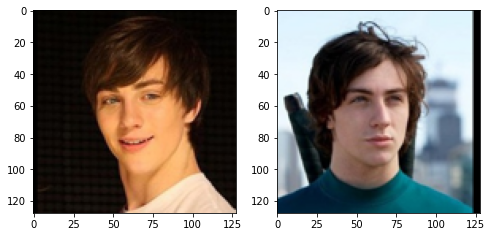

In [53]:
prediction_1 = model.predict([img_1, img_2])
print("same person" if prediction_1 > 0.5 else "not the same person", f"confidence: {prediction_1}")
plt.subplot(1, 2, 1)
plt.imshow(img_1[0])
plt.subplot(1, 2, 2)
plt.imshow(img_2[0])
plt.show()

not the same person confidence: [[0.06652458]]


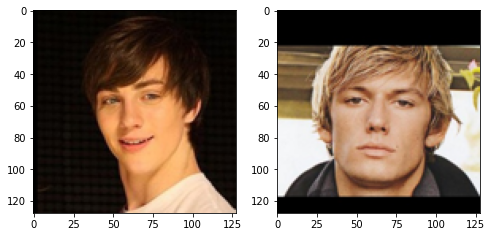

In [54]:
prediction_1 = model.predict([img_1, img_3])
print("same person" if prediction_1 > 0.5 else "not the same person", f"confidence: {prediction_1}")
plt.subplot(1, 2, 1)
plt.imshow(img_1[0])
plt.subplot(1, 2, 2)
plt.imshow(img_3[0])
plt.show()